## Initialize SQL database for Website implementation
---


In [89]:
import sqlite3

conn = sqlite3.connect('traffic_data .db')
cur = conn.cursor()



# Traffic Analysis - Roetersstraat, Amsterdam
- Dataset was provided by our Partner Klaas 
- Dataset is dat collected by two telraam sensors (camera sensors) on Roeterstraat (https://telraam.net/nl/location/9000009380)
## Who's on the Street ? 
---


In [90]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('raw_data.csv')
df['Date and Time (Local)'] = pd.to_datetime(df['Date and Time (Local)'])

# Calculate totals
total_pedestrians = df['Pedestrian Total'].sum()
total_bikes = df['Bike Total'].sum()
total_cars = df['Car Total'].sum()
total_heavy_vehicles = df['Large vehicle Total'].sum()
total_all = total_pedestrians + total_bikes + total_cars + total_heavy_vehicles

# Print percentages
print("Who's on the Street?\n")
print(f"Pedestrians: {total_pedestrians:,} ({total_pedestrians/total_all*100:.1f}%)")
print(f"Bikes: {total_bikes:,} ({total_bikes/total_all*100:.1f}%)")
print(f"Cars: {total_cars:,} ({total_cars/total_all*100:.1f}%)")
print(f"Heavy Vehicles: {total_heavy_vehicles:,} ({total_heavy_vehicles/total_all*100:.1f}%)")

Who's on the Street?

Pedestrians: 528,294 (39.3%)
Bikes: 420,472 (31.3%)
Cars: 310,784 (23.1%)
Heavy Vehicles: 84,254 (6.3%)


- mostly pedestrians on the street --> transforming into LTN is not such a bad idea 

### Add to Database

In [91]:
##create table
cur.execute("""
CREATE TABLE IF NOT EXISTS traffic_mode (
  id INTEGER PRIMARY KEY,
  pedestrians INTEGER,
  bikes INTEGER,
  cars INTEGER,
  heavy_vehicles INTEGER
);
""")
conn.commit()


In [92]:
#insert data 
cur.execute("""
INSERT INTO traffic_mode (pedestrians, bikes, cars, heavy_vehicles) VALUES (?, ?, ?, ?)""", (int(total_pedestrians), int(total_bikes), int(total_cars), int(total_heavy_vehicles)))
conn.commit()

## Who's Driving Above 30 km/h?
---
- Streets speedlimit is 30m/h



In [93]:
# Ensure all relevant columns are numeric (handle commas as decimal points)
for col in speed_columns + ['Car Total']:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace('%', '', regex=False)
        .astype(float)
    )

# Calculate counts for each speed range
for col in speed_columns:
    speed_range = col.replace('Speed Car ', '').replace(' (%)', '')
    df[f'Count {speed_range}'] = (df[col] / 100) * df['Car Total']

# Calculate under and over 30 km/h
df['Under 30 km/h'] = df['Count 0-10 km/h'] + df['Count 10-20 km/h'] + df['Count 20-30 km/h']
df['Over 30 km/h'] = (
    df['Count 30-40 km/h'] + df['Count 40-50 km/h'] +
    df['Count 50-60 km/h'] + df['Count 60-70 km/h'] + df['Count 70+ km/h']
)

# Remove NaN values
df_speed = df.dropna(subset=['Over 30 km/h'])

total_under = df_speed['Under 30 km/h'].sum()
total_over = df_speed['Over 30 km/h'].sum()
total_vehicles = total_under + total_over

# Print percentages
print("Speed Analysis: Over vs Under 30 km/h\n")
print(f"Vehicles under 30 km/h: {int(total_under):,} ({total_under/total_vehicles*100:.1f}%)")
print(f"Vehicles over 30 km/h: {int(total_over):,} ({total_over/total_vehicles*100:.1f}%)")

Speed Analysis: Over vs Under 30 km/h

Vehicles under 30 km/h: 143,183 (46.1%)
Vehicles over 30 km/h: 167,600 (53.9%)


- more than half drive faster than the speedlimit 
--> speedlimit needs to be enforced more 

- safety hazard 

### Add to Database 

In [94]:
#create table
cur.execute("""
CREATE TABLE IF NOT EXISTS speeding (
  id INTEGER PRIMARY KEY,
  over30 INTEGER,
  under30 INTEGER
);
""")
conn.commit()

In [95]:
#insert data 
cur.execute("""
INSERT INTO speeding (over30, under30) VALUES (?, ?)""", (int(total_over), int(total_under)))
conn.commit()

## Traffic Patterns at Different Times of Day
---

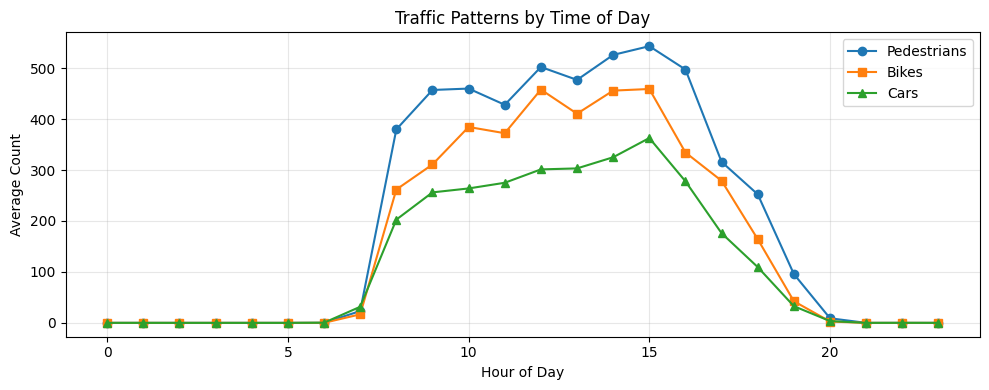

Peak hour for Pedestrians: 15:00
Peak hour for Bikes: 15:00
Peak hour for Cars: 15:00


In [96]:
import matplotlib.pyplot as plt

# Extract hour from datetime
df['Hour'] = df['Date and Time (Local)'].dt.hour

# Calculate average traffic by hour
hourly_avg = df.groupby('Hour')[['Pedestrian Total', 'Bike Total', 'Car Total']].mean()

# Create simple visualization
plt.figure(figsize=(10, 4))
plt.plot(hourly_avg.index, hourly_avg['Pedestrian Total'], label='Pedestrians', marker='o')
plt.plot(hourly_avg.index, hourly_avg['Bike Total'], label='Bikes', marker='s')
plt.plot(hourly_avg.index, hourly_avg['Car Total'], label='Cars', marker='^')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.title('Traffic Patterns by Time of Day')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find and print peak hours
peak_pedestrians = hourly_avg['Pedestrian Total'].idxmax()
peak_bikes = hourly_avg['Bike Total'].idxmax()
peak_cars = hourly_avg['Car Total'].idxmax()

print(f"Peak hour for Pedestrians: {peak_pedestrians}:00")
print(f"Peak hour for Bikes: {peak_bikes}:00")
print(f"Peak hour for Cars: {peak_cars}:00")

### Sensor does not pick up who exactly uses the street during 9pm - 6am (just one "Nightime" category) !!
- Remove those values as they are irrelevant
- also remove values where --> uptime = poor 

In [97]:
df['Date and Time (Local)'] = pd.to_datetime(df['Date and Time (Local)'])

df_filtered = df[(df['Date and Time (Local)'].dt.hour > 6) & (df['Date and Time (Local)'].dt.hour < 21)]
df_filtered = df_filtered[df_filtered['Uptime'] != 'Poor uptime - 0.5']
df_filtered = df_filtered.drop(['Night Total', 'Hour'], axis=1)

# Save to new CSV file
df_filtered.to_csv('filtered_traffic_data.csv', index=False)

print(f"Original data: {len(df)} rows")
print(f"Filtered data: {len(df_filtered)} rows")
print(f"Removed: {len(df) - len(df_filtered)} rows")

Original data: 2557 rows
Filtered data: 1487 rows
Removed: 1070 rows


## Sidewalk size 
---
- public dataset by gemeente(https://maps.amsterdam.nl/open_geodata/)
- comparing average Amsterdam side walk size with Roetersstraat in regards to safety (?)

In [98]:
sidewalk_df = pd.read_csv('SIDEWALKS.csv', sep=';')

#Filter out "Nog onbepaald" (not determined)
sidewalk_df = sidewalk_df[sidewalk_df['ComfortLevel'] != 'Nog onbepaald']

sidewalk_df['ComfortLevel_numeric'] = (sidewalk_df['ComfortLevel']
    .str.replace('m', '', regex=False)
    .str.replace('Smaller dan ', '', regex=False)
    .str.replace('Saller dan ', '', regex=False)
    .str.replace(' of breder', '', regex=False)
    .astype(float))

#Average per street
street_avg = sidewalk_df.groupby('Streetname')['ComfortLevel_numeric'].mean()

#Overall average
overall_avg = sidewalk_df['ComfortLevel_numeric'].mean()
print(f"Overall Average Sidewalk width: {overall_avg:.2f}m")

#Roetersstraat average
roetersstraat_avg = sidewalk_df[sidewalk_df['Streetname'] == 'Roetersstraat']['ComfortLevel_numeric'].mean()
percentage = (overall_avg - roetersstraat_avg) / overall_avg * 100
print(f"Roetersstraat Average Sidewalk width: {roetersstraat_avg:.2f}m")
print(f"Roetersstraat sidewalk width is {percentage:.2f}% smaller the Amsterdam average.")


Overall Average Sidewalk width: 1.90m
Roetersstraat Average Sidewalk width: 1.39m
Roetersstraat sidewalk width is 26.71% smaller the Amsterdam average.


- Roetersstraat average sidewalk width is smaller than the overall sidewalk width in Amsterdam, although mostly pedestrians use the street 

### Add to database 

In [99]:
##create table
cur.execute("""
CREATE TABLE IF NOT EXISTS sidewalk_size (
  id INTEGER PRIMARY KEY,
  amsterdam_avg STRING,
  roetersstraat_avg STRING
);
""")
conn.commit()

In [100]:
#insert data 
cur.execute("""
INSERT INTO sidewalk_size (amsterdam_avg, roetersstraat_avg) VALUES (?, ?)""", (overall_avg, roetersstraat_avg))
conn.commit()

## Speed Distribution Roetersstraat 
---


In [101]:
traffic_df = pd.read_csv('filtered_traffic_data.csv')

# Calculate speed distribution from actual traffic data
speed_cols = ['Speed Car 0-10 km/h (%)', 'Speed Car 10-20 km/h (%)', 'Speed Car 20-30 km/h (%)',
              'Speed Car 30-40 km/h (%)', 'Speed Car 40-50 km/h (%)', 'Speed Car 50-60 km/h (%)',
              'Speed Car 60-70 km/h (%)', 'Speed Car 70+ km/h (%)']

# Average percentage across all observations
speed_dist = traffic_df[speed_cols].mean()
speed_ranges = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

average_speeds = {}

print("Speed Distribution on Roetersstraat:\n")
for speed_range, percentage in zip(speed_ranges, speed_dist):
    if percentage >= 10.0:
        average_speeds[speed_range] = percentage
        print(f"{speed_range} km/h: {percentage:.1f}%")


Speed Distribution on Roetersstraat:

10-20 km/h: 11.3%
20-30 km/h: 20.4%
30-40 km/h: 21.1%
40-50 km/h: 10.5%


### Add to Database

In [102]:
#create table
cur.execute("""
CREATE TABLE IF NOT EXISTS speed_distribution (
  id INTEGER PRIMARY KEY,
  speed_0_10 REAL,
  speed_10_20 REAL,
  speed_20_30 REAL,
  speed_30_40 REAL,
  speed_40_50 REAL,
  speed_50_60 REAL,
  speed_60_70 REAL,
  speed_70_plus REAL
);
""")
conn.commit()

In [103]:
#insert data
cur.execute("""
    INSERT INTO speed_distribution (
        speed_0_10, speed_10_20, speed_20_30, speed_30_40,
        speed_40_50, speed_50_60, speed_60_70, speed_70_plus
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
""", tuple(float(x) for x in speed_dist))
conn.commit()

## Noise Pollution
---


- Uses a simplified logarithmic noise model based on vehicle count, speed, and vehicle type

- Random Forest Training: Trains 100 decision trees on the CNOSSOS-EU calculations to learn complex patterns between traffic conditions and noise levels, using 80% of data for training and 20% for validation

- Speed-Based Predictions: The trained model predicts noise levels for the average speeds distribution 

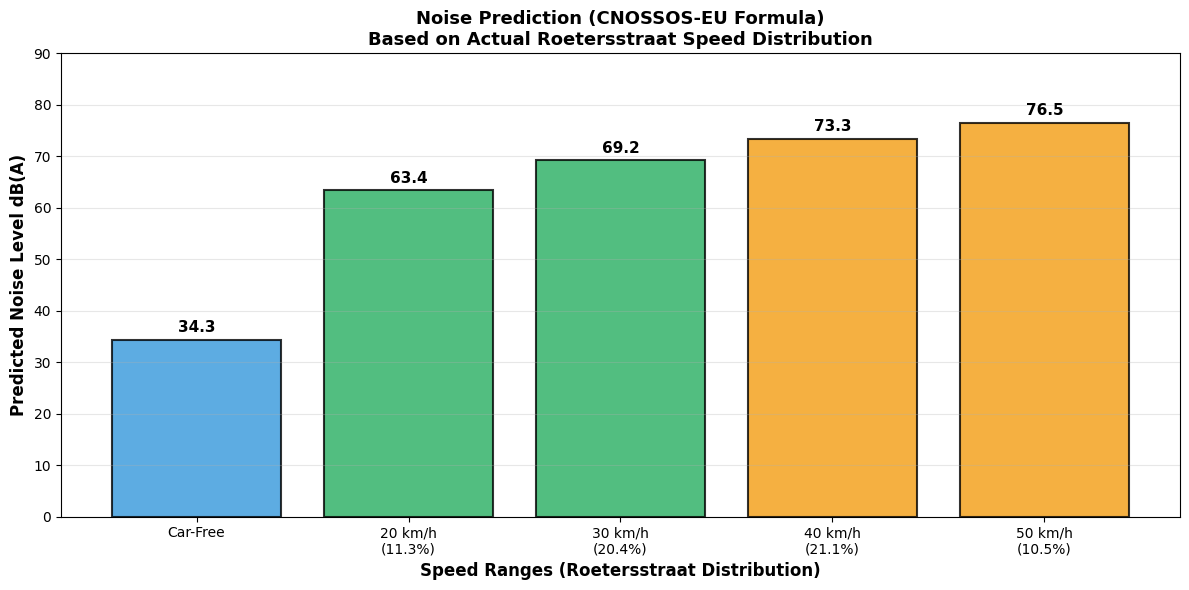

In [21]:
# Noise prediction using only the CNOSSOS-EU formula (no ML)
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('filtered_traffic_data.csv')

def calculate_noise_cnossos(speed, cars, heavy):
    L_light = 10 * np.log10(cars + 0.1) + 33 * np.log10(speed / 70) + 54.2
    L_heavy = 10 * np.log10(heavy + 0.1) + 33 * np.log10(speed / 70) + 61.5
    return 10 * np.log10(10**(L_light/10) + 10**(L_heavy/10))

# Use actual Roetersstraat speed distribution
avg_cars = df['Car Total'].mean()
avg_heavy = df['Large vehicle Total'].mean()

# Use average_speeds from previous cell (speed ranges and their percentages)
speed_ranges = list(average_speeds.keys())
speeds = [int(s.split('-')[1]) for s in speed_ranges]  # Get upper bound of each range
percentages = list(average_speeds.values())

# Calculate noise for each speed range using the formula
db_levels = [calculate_noise_cnossos(s, avg_cars, avg_heavy) for s in speeds]
car_free_db = calculate_noise_cnossos(20, 0, 0)  # Example: car-free scenario at 20 km/h

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
labels = ['Car-Free'] + [f'{s} km/h\n({p:.1f}%)' for s, p in zip(speeds, percentages)]
noise_levels = [car_free_db] + db_levels
colors = ['#3498db'] + ['#27ae60' if s <= 30 else '#f39c12' if s <= 50 else '#e74c3c' for s in speeds]
bars = ax.bar(labels, noise_levels, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Predicted Noise Level dB(A)', fontsize=12, fontweight='bold')
ax.set_xlabel('Speed Ranges (Roetersstraat Distribution)', fontsize=12, fontweight='bold')
ax.set_title('Noise Prediction (CNOSSOS-EU Formula)\nBased on Actual Roetersstraat Speed Distribution', fontsize=13, fontweight='bold')
ax.set_ylim(0, 90)
ax.grid(axis='y', alpha=0.3)
for bar, noise in zip(bars, noise_levels):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, f'{noise:.1f}', ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

- noise level would be reduced by a lot, if transformed into LTN

- enforcing the speed limit would also decrease noise levels 

## London casualties
---

- datasource = https://tfl.gov.uk/corporate/publications-and-reports/road-safety 
- filtered by Hackney --> most LTNs there

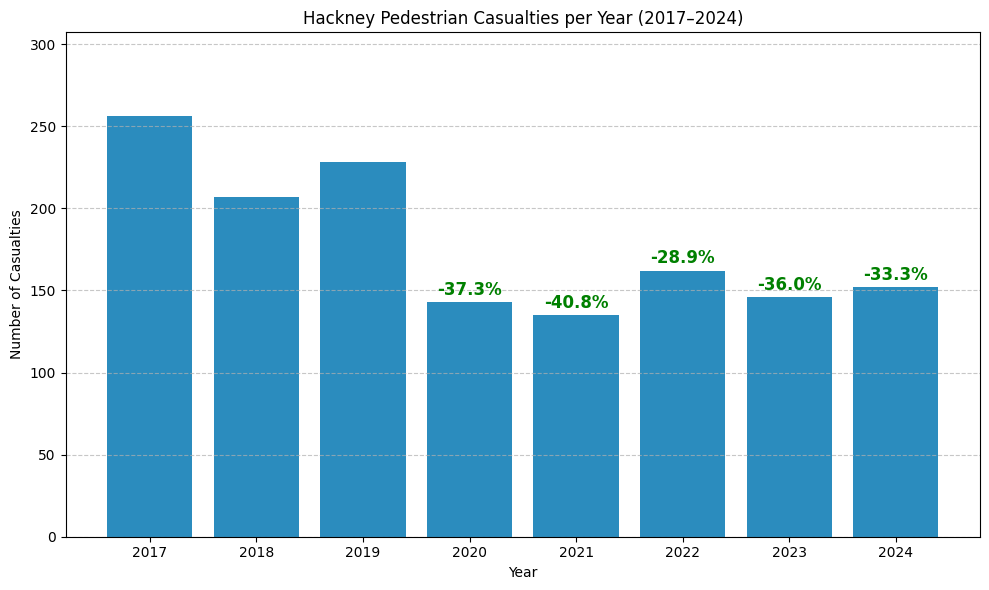

   Year  Casualties
0  2017         256
1  2018         207
2  2019         228
3  2020         143
4  2021         135
5  2022         162
6  2023         146
7  2024         152
Total percentage decline from 2019 to 2024: -33.3%


In [109]:
# Hackney pedestrian casualties per year (2017–2024) — simplified and robust
import re
import pandas as pd
import matplotlib.pyplot as plt

excel_path = "casualties.xlsx"
# load table and normalise column names
table = pd.read_excel(excel_path, sheet_name="Table 12", header=3)
table.columns = [str(c).strip() for c in table.columns]

# helper to find columns
def find_col(keyword):
    return next((c for c in table.columns if keyword.lower() in c.lower()), None)

borough_col = find_col('borough')
mode_col = find_col('mode')
severity_col = find_col('severity')

if not all([borough_col, mode_col, severity_col]):
    print("Could not find required columns. Available columns:", table.columns.tolist())
else:
    mask = (
        table[borough_col].astype(str).str.strip().str.lower().eq('hackney') &
        table[mode_col].astype(str).str.strip().str.lower().eq('pedestrian') &
        table[severity_col].astype(str).str.strip().str.lower().eq('total')
    )
    rows = table[mask]

    years = [str(y) for y in range(2017, 2025)]
    values = []
    for y in years:
        year_cols = [c for c in table.columns if re.search(r'\b' + re.escape(y) + r'\b', str(c))]
        if not year_cols:
            values.append(0)
        else:
            s = rows[year_cols].apply(pd.to_numeric, errors='coerce').sum().sum()
            values.append(int(s) if not pd.isna(s) else 0)

    # compute percentage decline relative to 2019
    idx_2019 = years.index('2019') if '2019' in years else None
    if idx_2019 is not None and values[idx_2019] > 0:
        base = values[idx_2019]
        percent_decline = [((base - v) / base) * 100 for v in values[idx_2019:]]
    else:
        percent_decline = []

    # plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(years, values, color="#2b8cbe")
    plt.title("Hackney Pedestrian Casualties per Year (2017–2024)")
    plt.xlabel("Year")
    plt.ylabel("Number of Casualties")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if any(values):
        plt.ylim(0, max(values) * 1.2)

    for i, bar in enumerate(bars):
        label = ""
        if idx_2019 is not None and i > idx_2019 and percent_decline:
            label = f"-{percent_decline[i - idx_2019]:.1f}%"
        plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 2, label, ha='center', va='bottom', color='green', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(pd.DataFrame({'Year': years, 'Casualties': values}))
    if percent_decline:
        print(f"Total percentage decline from 2019 to {years[-1]}: -{percent_decline[-1]:.1f}%")